# Benchmark Modell 2 with MPA

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import sys
sys.path.append('../..')
from helper.lazy_regression import TooLazyForRegression
from sklearn.feature_selection import RFECV
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

from statsmodels.regression.linear_model import WLS

pd.options.display.max_columns = None

In [2]:
data = pd.read_table('../../data/data_mpa.txt', sep=' ')
feature_cols = data.columns.to_list()
feature_cols.remove('size_mm')
feature_cols.remove('start_time')

In [4]:
data = data.sample(frac=1, random_state=42).reset_index(drop=True)
X,y = data[feature_cols], data['size_mm']
X.head(2)

,packnr,velocity,centroid_frequency_M01,centroid_frequency2_M01,centroid_frequency_M02,centroid_frequency2_M02,centroid_frequency_M03,centroid_frequency2_M03,centroid_frequency_M04,centroid_frequency2_M04,median_freq_M01,median_freq_M02,median_freq_M03,median_freq_M04,flash_ind_M01,flash_ind_M02,flash_ind_M03,flash_ind_M04,cv_M01,cv_M02,cv_M03,cv_M04,iqa_M01,iqa_M02,iqa_M03,iqa_M04,mab_M01,mab_M02,mab_M03,mab_M04,imp_M01,imp_M02,imp_M03,imp_M04,len_M01,len_M02,len_M03,len_M04
0,70,3.2,2802.695768,2790.699648,2899.675769,3025.867621,2771.059285,2948.871286,2602.512787,2749.648107,2777.277778,2801.584601,2971.752164,2778.106152,0.001072,0.002973,0.002294,0.003090,0.653272,0.663823,0.732801,0.659685,1.173204e-04,9.797752e-07,1.100824e-06,6.926820e-07,0.526466,0.044487,0.043126,0.041214,3,0,0,0,37,37,37,37
1,3,1.8,2666.230040,2761.489272,2069.359622,1733.914199,2201.514265,2004.093932,3311.008391,3316.603387,2846.010967,1665.540403,2222.440664,3264.753799,0.003646,0.003061,0.004036,0.001696,0.512738,0.649669,0.508016,1.014074,2.495207e-08,2.200980e-08,5.975374e-08,7.631775e-05,0.006773,0.004704,0.007177,0.523846,0,0,0,1,44,44,44,44


In [5]:
data.shape

(86747, 40)

## Select Best Feature for Benchmark

In [4]:
from sklearn.metrics import r2_score
from sklearn.feature_selection import SequentialFeatureSelector

In [5]:
best_feature_dict = {}
best_feature_cvscores = {}
for n_features in tqdm(np.arange(1,10+1)):
    select = SequentialFeatureSelector(estimator=LinearRegression(), 
                                       n_features_to_select=n_features, 
                                       direction='forward', 
                                       scoring='r2')
    select.fit(X, np.log(y))
    best_col = X.columns.to_numpy()[select.get_support()]
    best_feature_dict[n_features] = best_col
    best_feature_cvscores[n_features] = cross_val_score(estimator=LinearRegression(),
                                                        X=X[best_col], 
                                                        y=np.log(y), cv=10, 
                                                        scoring='r2')

100%|██████████| 10/10 [01:02<00:00,  6.24s/it]


In [6]:
tmp = pd.melt(pd.DataFrame.from_dict(best_feature_cvscores), var_name='n_feature', value_name='score')
tmp['score'] = np.abs(tmp['score'])
tmp.head(2)

,n_feature,score
0,1,0.534309
1,1,0.538646


In [7]:
tmp_ = tmp.groupby('n_feature').mean()

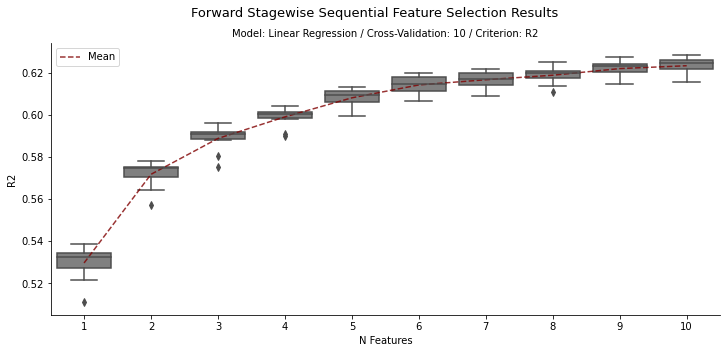

In [8]:
fig = plt.subplots(figsize=(12, 5))
p = sns.boxplot(x=tmp['n_feature'], y=tmp['score'], color='grey')
p1 = sns.lineplot(x=tmp_.index-1, y=tmp_.to_numpy().reshape(-1), color='maroon', 
                  linestyle='--', label='Mean', alpha=.8)
plt.title(r'Model: Linear Regression / Cross-Validation: 10 / Criterion: R2', fontsize=10)
plt.suptitle('Forward Stagewise Sequential Feature Selection Results', fontsize=13)
plt.xlabel('N Features')
plt.ylabel(r'R2')
sns.despine()
plt.show()

In [9]:
n_features = 5
best_feature_dict[n_features]

array(['centroid_frequency_M01', 'centroid_frequency2_M04',
       'median_freq_M04', 'cv_M04', 'imp_M04'], dtype=object)

In [10]:
X_best = X[best_feature_dict[n_features]]

## Hyperparameter 

In [11]:
from sklearn.linear_model import LinearRegression

In [12]:
results = cross_val_score(estimator=LinearRegression(), X=X_best, y=np.log(y), cv=10)
print('CV Results:\n', results)
print('Mean Resutls: ', np.mean(results))

CV Results:
 [0.60903539 0.6127885  0.60575239 0.59960816 0.60993733 0.6130987
 0.60712967 0.61114504 0.610825   0.60071343]
Mean Resutls:  0.6080033611622575


## With Max-Feature

In [6]:
from helper.feature_extract import extract_highest_amplitude_features_with_mp

In [7]:
df_max = extract_highest_amplitude_features_with_mp(df=data, sensor_types=[['M01', 'M02', 'M03', 'M04']],
                                                  create_one_sensor_feature=True, n_processes=4, 
                                                  keep_columns=False)

INFO || Extracting Max Features for types: ['M01', 'M02', 'M03', 'M04']


In [8]:
feature_cols = df_max.columns.to_list()
feature_cols.remove('size_mm')
feature_cols.remove('start_time')

In [9]:
X,y = df_max[feature_cols], df_max['size_mm']
X.head(2)

,packnr,velocity,max_centroid_frequency_M,max_centroid_frequency2_M,max_median_freq_M,max_flash_ind_M,max_cv_M,max_iqa_M,max_mab_M,max_imp_M,max_len_M
0,70,3.2,2802.695768,2790.699648,2777.277778,0.001072,0.653272,0.000117,0.526466,3,37
1,3,1.8,3311.008391,3316.603387,3264.753799,0.001696,1.014074,0.000076,0.523846,1,44


In [10]:
df_max.shape

(86747, 13)

In [26]:
best_feature_dict = {}
best_feature_cvscores = {}
for n_features in tqdm(np.arange(1,10+1)):
    select = SequentialFeatureSelector(estimator=LinearRegression(), 
                                       n_features_to_select=n_features, 
                                       direction='forward', 
                                       scoring='r2')
    select.fit(X, np.log(y))
    best_col = X.columns.to_numpy()[select.get_support()]
    best_feature_dict[n_features] = best_col
    best_feature_cvscores[n_features] = cross_val_score(estimator=LinearRegression(),
                                                        X=X[best_col], 
                                                        y=np.log(y), cv=10, 
                                                        scoring='r2')

100%|██████████| 10/10 [00:13<00:00,  1.35s/it]


In [27]:
tmp = pd.melt(pd.DataFrame.from_dict(best_feature_cvscores), var_name='n_feature', value_name='score')
tmp['score'] = np.abs(tmp['score'])
tmp_ = tmp.groupby('n_feature').mean()

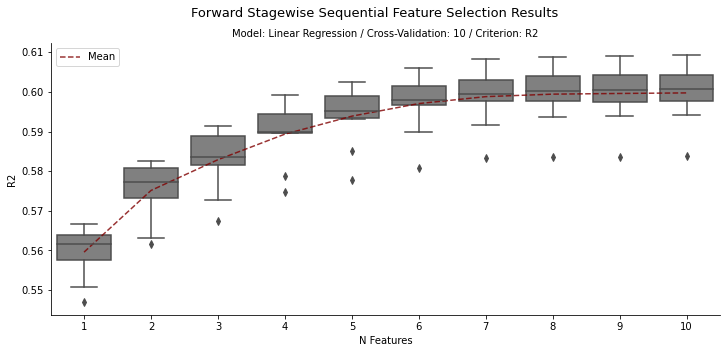

In [28]:
fig = plt.subplots(figsize=(12, 5))
p = sns.boxplot(x=tmp['n_feature'], y=tmp['score'], color='grey')
p1 = sns.lineplot(x=tmp_.index-1, y=tmp_.to_numpy().reshape(-1), color='maroon', 
                  linestyle='--', label='Mean', alpha=.8)
plt.title(r'Model: Linear Regression / Cross-Validation: 10 / Criterion: R2', fontsize=10)
plt.suptitle('Forward Stagewise Sequential Feature Selection Results', fontsize=13)
plt.xlabel('N Features')
plt.ylabel(r'R2')
sns.despine()
plt.show()

In [29]:
n_features = 5
best_feature_dict[n_features]

array(['max_centroid_frequency_M', 'max_centroid_frequency2_M',
       'max_median_freq_M', 'max_flash_ind_M', 'max_mab_M'], dtype=object)

In [30]:
X_best = X[best_feature_dict[n_features]]

In [31]:
results = cross_val_score(estimator=LinearRegression(), X=X_best, y=np.log(y), cv=10)
print('CV Results:\n', results)
print('Mean Resutls: ', np.mean(results))

CV Results:
 [0.59986529 0.59419176 0.59508052 0.58510669 0.59577037 0.60247243
 0.59535161 0.59992278 0.59319632 0.57787781]
Mean Resutls:  0.5938835569972755
